<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Update:---Bjørn's-reported-aero.Mw-error-fixed-(see-#pha-2018/3/19)" data-toc-modified-id="Update:---Bjørn's-reported-aero.Mw-error-fixed-(see-#pha-2018/3/19)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Update:   Bjørn's reported aero.Mw error fixed (see #pha 2018/3/19)</a></span></li><li><span><a href="#Use-a405.dropgrow.aerolib-to-find-equilibrium-drop-radii" data-toc-modified-id="Use-a405.dropgrow.aerolib-to-find-equilibrium-drop-radii-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Use a405.dropgrow.aerolib to find equilibrium drop radii</a></span></li><li><span><a href="#Read-in-the-inital-conditions-from-a-json-file" data-toc-modified-id="Read-in-the-inital-conditions-from-a-json-file-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read in the inital conditions from a json file</a></span></li><li><span><a href="#Calculate-the-lognormal-aerosol-mass-distribution-and-get-the-number-concentration-in-each-of-30-bins" data-toc-modified-id="Calculate-the-lognormal-aerosol-mass-distribution-and-get-the-number-concentration-in-each-of-30-bins-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate the lognormal aerosol mass distribution and get the number concentration in each of 30 bins</a></span><ul class="toc-item"><li><span><a href="#Find-the-number-of-aerosols-in-each-bin" data-toc-modified-id="Find-the-number-of-aerosols-in-each-bin-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Find the number of aerosols in each bin</a></span></li><li><span><a href="#Find-the-equilibrium-radius-for-each-of-the-30-aerosol-masses" data-toc-modified-id="Find-the-equilibrium-radius-for-each-of-the-30-aerosol-masses-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Find the equilibrium radius for each of the 30 aerosol masses</a></span><ul class="toc-item"><li><span><a href="#Calculating-the-equilibrium-size-distribution-for-unactivated-aerosols" data-toc-modified-id="Calculating-the-equilibrium-size-distribution-for-unactivated-aerosols-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Calculating the equilibrium size distribution for unactivated aerosols</a></span></li></ul></li></ul></li></ul></div>

# Update:   Bjørn's reported aero.Mw error fixed (see #pha 2018/3/19)

# Use a405.dropgrow.aerolib to find equilibrium drop radii

In [1]:
import a405.dropgrow.aerolib
#
# new library for aerosol functions
#
from a405.dropgrow.aerolib import lognormal,create_koehler,find_koehler_coeffs
import numpy as np
from a405.utils.helper_funs import make_tuple, find_centers
from a405.thermo.rootfinder import find_interval, fzero
import json
import importlib_resources as ir  #pip install importlib_resources
import pandas as pd
#
# load pprint to print the yaml input
#
import pprint
pp = pprint.PrettyPrinter(indent=4)


# Read in the inital conditions from a json file


In [2]:
#
# use the importlib_resources module to 
# find the path to the data folder.  The file
# is located at a405/data/dropgrow.json
#
with ir.open_text('a405.data','dropgrow.json') as f:
    input_dict=json.load(f)
pp.pprint(input_dict)

{   'aerosol': {   'Ms': 114,
                   'Mw': 18.0,
                   'Sigma': 0.075,
                   'rhoaero': 1775,
                   'sd': 1.7,
                   'themean': 2e-17,
                   'totmass': 1.5e-09,
                   'vanHoff': 2.0},
    'dir_name': 'dump_run',
    'dump_output': True,
    'initial_conditions': {   'Pinit': 90000.0,
                              'Sinit': 0.995,
                              'Tinit': 280.0,
                              'Zinit': 1000.0,
                              'wvel': 0.5},
    'integration': {'dt': 1, 'tend': 200, 'tstart': 0},
    'output_file': 'outfile'}


# Calculate the lognormal aerosol mass distribution and get the number concentration in each of 30 bins

(code borrowed from aero.ipynb)

## Find the number of aerosols in each bin

In [3]:
mass_vals = np.linspace(-20,-16,30)
mass_vals = 10**mass_vals
mu=input_dict['aerosol']['themean']
sigma = input_dict['aerosol']['sd']
totmass = input_dict['aerosol']['totmass']
mdist = totmass*lognormal(mass_vals,np.log(mu),np.log(sigma))
mdist = find_centers(mdist)*np.diff(mass_vals)
center_mass = find_centers(mass_vals)
ndist = mdist/center_mass

## Find the equilibrium radius for each of the 30 aerosol masses

(code borrowed from koehler.ipynb)

First make two debugging print functions ('info' and 'g') to easily print various floating point values.

In [4]:
def make_format(format_string="{:8.3g}"):
    """
    returns a function that formats with format_string
    """
    def inner_fun(value):
        return format_string.format(value)
    return inner_fun

#Now get closures from make_format and use it:

g = make_format()
info = make_format(format_string="debugging {}")

a=10
b=1.546e-23
print(info(a), g(b))


debugging 10 1.55e-23


### Calculating the equilibrium size distribution for unactivated aerosols

Below we use the rootfinder to search on log(radius) to find the equilibrium
drop size for unactivaed aerosols on the left side of their Koehler curves

In [5]:
aero=make_tuple(input_dict['aerosol'])
parcel=make_tuple(input_dict['initial_conditions'])

a, b = find_koehler_coeffs(aero,parcel)

#
# sanity check
#
m=1.e-18
Scrit=(4.*a**3./(27.*b*m))**0.5;
rcrit = (3.*m*b/a)**0.5
print(("for aerosol with mass = {} kg, "
       "SScrit,rcrit are {:8.3g}, {:8.3g} microns")
        .format(m,Scrit,rcrit*1.e6))


for aerosol with mass = 1e-18 kg, SScrit,rcrit are  0.00175,    0.441 microns


In [6]:
koehler_fun = create_koehler(aero,parcel)

def find_diff(logr,S_target,m):
    """
    zero function for rootfinder
    """
    r = np.exp(logr)
    return S_target - koehler_fun(r,m)

S_target = parcel.Sinit
logr_start = np.log(0.1e-6)

initial_radius = []
for mass in center_mass:
    brackets = np.array(find_interval(find_diff,logr_start,S_target,mass))
    left_bracket, right_bracket = np.exp(brackets)*1.e6  #get brackets in microns for printing
    equil_rad = np.exp(fzero(find_diff,brackets,S_target,mass))
    
    Scrit=(4.*a**3./(27.*b*mass))**0.5
    
    initial_radius.append(equil_rad)
    print((f'mass = {mass:6.3g} kg\n'
           f'left bracket = {left_bracket:8.3e} microns\n'
           f'right bracket={right_bracket:8.3e} microns\n'
           f'critical supersaturation: {Scrit:6.3g}'))
    print(f'equlibrium radius at S={S_target} is {equil_rad*1.e6:5.3f} microns\n')
   


mass = 1.19e-20 kg
left bracket = 6.194e-01 microns
right bracket=1.615e-02 microns
critical supersaturation: 0.0161
equlibrium radius at S=0.995 is 0.026 microns

mass = 1.63e-20 kg
left bracket = 3.631e-01 microns
right bracket=2.754e-02 microns
critical supersaturation: 0.0137
equlibrium radius at S=0.995 is 0.030 microns

mass = 2.24e-20 kg
left bracket = 3.631e-01 microns
right bracket=2.754e-02 microns
critical supersaturation: 0.0117
equlibrium radius at S=0.995 is 0.035 microns

mass = 3.08e-20 kg
left bracket = 2.489e-01 microns
right bracket=4.018e-02 microns
critical supersaturation: 0.00999
equlibrium radius at S=0.995 is 0.041 microns

mass = 4.23e-20 kg
left bracket = 2.489e-01 microns
right bracket=4.018e-02 microns
critical supersaturation: 0.00853
equlibrium radius at S=0.995 is 0.047 microns

mass = 5.81e-20 kg
left bracket = 1.905e-01 microns
right bracket=5.248e-02 microns
critical supersaturation: 0.00727
equlibrium radius at S=0.995 is 0.055 microns

mass = 7.98e-

In [7]:
from a405.thermo.constants import constants as c
import matplotlib.pyplot as plt

def find_vols(aerosol_mass,drop_radius):
    aero_vol = aerosol_mass/aero.rhoaero
    drop_vol = 4./3.*np.pi*drop_radius**3.
    water_vol = drop_vol - aero_vol
    return (aero_vol,water_vol)

def find_ratios(aerosol_mass,aero_vol,water_vol):
    total_vol = water_vol + aero_vol
    ns = aerosol_mass/aero.Ms   #pha 2018/03/19
    nw_exact = water_vol*c.rhol/aero.Mw
    nw_approx = total_vol*c.rhol/aero.Mw
    return (ns/nw_approx, ns/nw_exact)
    
paired_vals = zip(center_mass,initial_radius) 
ratios = []
for mass,radius in paired_vals:
    aero_vol, water_vol = find_vols(mass,radius)
    approx_ratio,exact_ratio = find_ratios(mass,aero_vol,water_vol)
    ratios.append((approx_ratio,exact_ratio))
df_out = pd.DataFrame.from_records(ratios,columns=['approx','exact'])

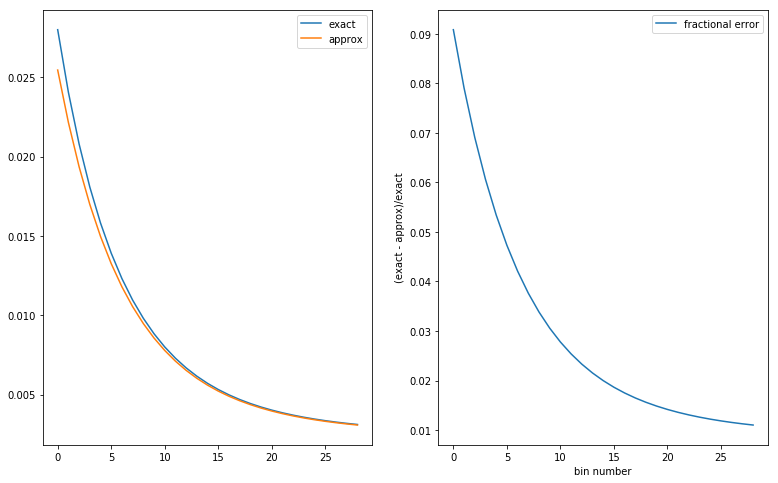

In [8]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(13,8))
ax0.plot('exact',label='exact',data=df_out)
ax0.plot('approx',label='approx',data=df_out)
ax0.legend()
ax1.plot((df_out['exact'] - df_out['approx'])/df_out['exact'],label='fractional error')
ax1.legend()
ax1.set(xlabel='bin number',ylabel='$n_s/n_w$')
out=ax1.set(xlabel='bin number',ylabel='(exact - approx)/exact')